## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier

## Functions

In [3]:
# functions
def get_values(df):
    X_lex = df['WORD'].str.strip()
    X_lex = X_lex.values

    y_lex = df['POS'].str.strip()
    y_lex = y_lex.values

    return X_lex, y_lex
def list_all_POS_tags(y) :
    list_tags = []
    for tag_list in y :
        tags = tag_list.split()
        for tag in tags :
            if tag not in list_tags :
                list_tags.append(tag)
    return list_tags

def set_up_POS_tag_encoder(list_tags) :
    encoder_tag = LabelEncoder().fit(list_tags)
    return encoder_tag

# vec encoding of words
def alpha_vec2(w, mx, max_word_len, dic):
    vec = np.zeros((max_word_len, len(dic)))
    for i in range(0, len(w)):
        vec[i] = mx[np.where(dic == w[i])[0][0]]
    vec = vec.astype('float16').flatten()

    vec=vec.astype('float16').flatten()
    vec[vec==np.inf]=0
    vec[vec==-np.inf]=0
    return vec


## Import & clean data

In [2]:
columns = ["ID", "WORD", "LEMMA", "POS", "XPOS", "MORPH", "HEAD", "DEPREL", "DEPS", "MISC"]

# Read the file and convert it to a DataFrame
df = pd.read_csv('kdt-NLANU-0.01.connlu.txt\kdt-NLANU-0.01.connlu.txt', 
                 sep='\t', 
                 names=columns, 
                 skip_blank_lines=True)

# Drop rows where 'WORD' is NaN
df = df.dropna(subset=['WORD'])

# Remove punctuation characters
df = df[df['POS'] != 'PUNCT']

# Some characters to remove
chars_to_remove = r"[\#\$\%\&\(\)\+\,\-\.\–\’\:\@]"

# Removing the characters from the 'WORD' column
df['WORD'] = df['WORD'].str.replace(chars_to_remove,
                                    '',
                                    regex=True
                                    )
df = df[df['POS'] != 'X']

df = df.sample(n=400000, # for computational reasons 
               random_state=42
               )

df.head()

<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:4: SyntaxWarning: invalid escape sequence '\k'
C:\Users\Olivier\AppData\Local\Temp\ipykernel_6032\655577811.py:4: SyntaxWarning: invalid escape sequence '\k'
  df = pd.read_csv('kdt-NLANU-0.01.connlu.txt\kdt-NLANU-0.01.connlu.txt',


,ID,WORD,LEMMA,POS,XPOS,MORPH,HEAD,DEPREL,DEPS,MISC
626192,4,өткен,өт,VERB,VERB,vbType=Adj,5,acl-relcl,_,_
668143,14,сайлаудағы,сайлаудағы,ADJ,ADJ,_,15,amod,_,_
688831,4,төрт,төрт,NUM,NUM,_,5,nummod,_,_
825240,5,шаруа,шаруа,NOUN,NOUN,_,6,nmod-poss,_,_
402427,8,100,100,NUM,NUM,_,10,nummod,_,_


In [11]:
# Split into train & test sets
X_lex, Y_lex = get_values(df)

X_train, X_test, y_train, y_test = train_test_split(X_lex, 
                                                    Y_lex, 
                                                    test_size=0.1, 
                                                    random_state=42
                                                    )

#get max word length
max_word_len=max(max([len(w) for w in Y_lex]),max([len(w) for w in X_lex]))

#Char2vec model
vectorizer = TfidfVectorizer(lowercase=False, 
                             analyzer='char'
                             )

X = vectorizer.fit_transform(X_lex)
dic=vectorizer.get_feature_names_out() # letter dictionary
num_letters=len(dic)
mx=X.T.dot(X) # letter cooccurence matrix
mx=mx.toarray()


In [5]:
#Vectorize X only
X_lex_vec_train=[alpha_vec2(w, mx, max_word_len, dic) for w in X_train]
X_lex_vec_test=[alpha_vec2(w, mx, max_word_len, dic) for w in X_test]

# Encode Y
list_tags = list_all_POS_tags(y = y_train)
encoder_tag = LabelEncoder().fit(list_tags)

Y_train = encoder_tag.transform(y_train)
Y_test = encoder_tag.transform(y_test)

## Classification

In [6]:
# Build & train model
best_model=ExtraTreesClassifier(n_estimators=10,
                                n_jobs=-1,
                                criterion='entropy',
                                bootstrap=True,
                                verbose=2
                                )

best_model.fit(X_lex_vec_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10building tree 2 of 10
building tree 3 of 10
building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


ExtraTreesClassifier(bootstrap=True, criterion='entropy', n_estimators=10,
                     n_jobs=-1, verbose=2)

In [7]:
# predict both train and test sets
predicts_test=best_model.predict(X_lex_vec_test)
predicts_train=best_model.predict(X_lex_vec_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    7.0s finished


## Results analysis

In [8]:
# Calculate results

test_acc = accuracy_score(Y_test,
                          predicts_test
                          )
test_f1 = f1_score(Y_test,
                   predicts_test,
                   average = "weighted"
                   )

train_acc = accuracy_score(Y_train,
                           predicts_train
                           )
train_f1 = f1_score(Y_train,
                    predicts_train,
                    average = "weighted"
                    )

print("Test Accuracy:", round(test_acc, 3))
print("Test F1 Score:", round(test_f1, 3))
print("Train Accuracy:", round(train_acc, 3))
print("Train F1 Score:", round(train_f1, 3))

Test Accuracy: 0.934
Test F1 Score: 0.932
Train Accuracy: 0.948
Train F1 Score: 0.947


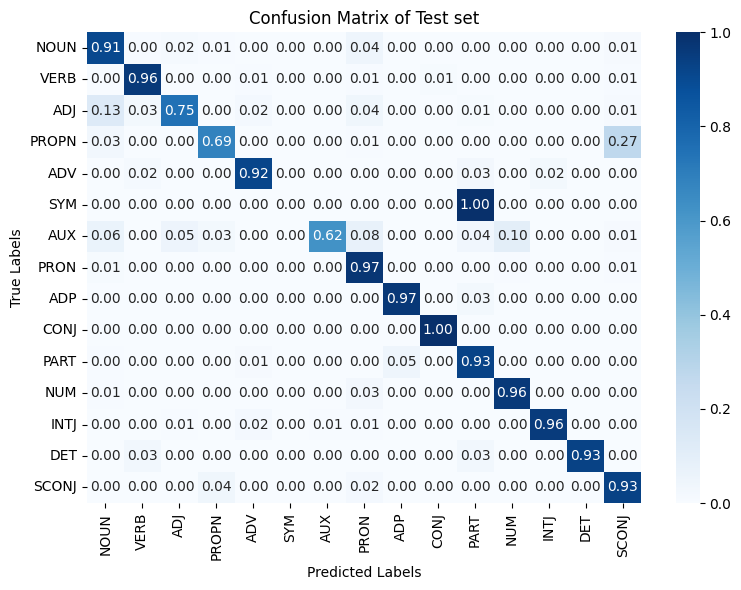

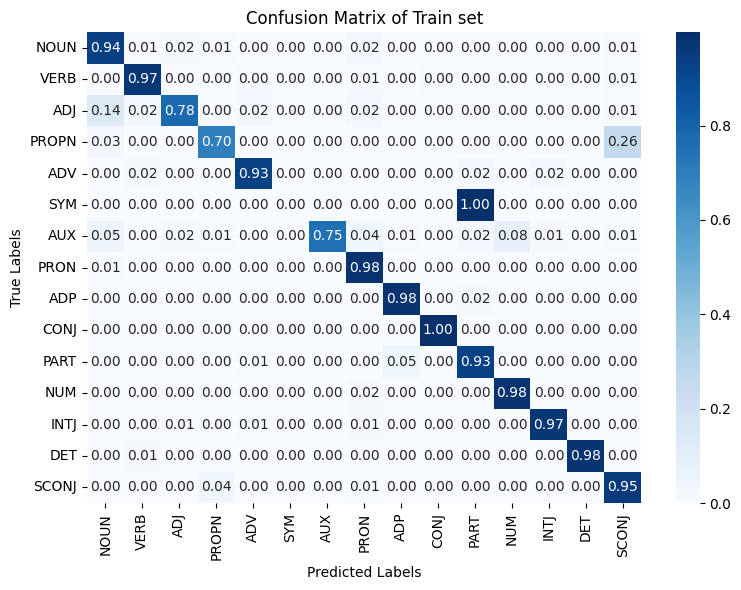

In [9]:
def plot_confusion_matrix(Y, predicts, list_tags, title):
  
  cm = confusion_matrix(Y, 
                        predicts, 
                        labels=np.arange(len(list_tags))
                        )

  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_normalized,
              annot=True,
              fmt='.2f',
              cmap='Blues',
              xticklabels=list_tags,
              yticklabels=list_tags)
  title = 'Confusion Matrix of ' + title
  plt.title(title)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')

  plt.tight_layout()
  plt.show()


plot_confusion_matrix(Y_test, predicts_test, list_tags, 'Test set')
plot_confusion_matrix(Y_train, predicts_train, list_tags, 'Train set')

In [37]:
def per_tag_accuracy(y_true, y_pred, list_tags, encoder):
    tag_names = []
    accuracies = []

    for tag in list_tags:
        encoded_tag = encoder.transform([tag])[0]
        idx = np.where(y_true == encoded_tag)
        acc = accuracy_score(y_true[idx], 
                             y_pred[idx]
                             )
        tag_names.append(tag)
        accuracies.append(acc)

    df_accuracy = pd.DataFrame({
        'Tag': tag_names,
        'Accuracy': accuracies
    })

    return df_accuracy

df_tag_acc = per_tag_accuracy(Y_test, 
                              predicts_test, 
                              list_tags, 
                              encoder_tag
                              )

df_tag_acc # display accuracy per Tag

,Tag,Accuracy
0,NOUN,0.973194
1,VERB,0.932055
2,ADJ,0.910107
3,PROPN,0.964386
4,ADV,0.749326
5,SYM,0.933333
6,AUX,0.686707
7,PRON,0.928117
8,ADP,0.963764
9,CONJ,0.921132


In [40]:
def tag_prediction_nb(y_true, y_pred, list_tags, encoder):

    tag_names = []
    correct_counts = []
    incorrect_counts = []

    for tag in list_tags:
        encoded_tag = encoder.transform([tag])[0]
        idx = np.where(y_true == encoded_tag)
        
        correct = np.sum(y_true[idx] == y_pred[idx])
        incorrect = len(y_true[idx]) - correct

        tag_names.append(tag)
        correct_counts.append(correct)
        incorrect_counts.append(incorrect)

    df_distribution = pd.DataFrame({
        'Tag': tag_names,
        'Correct Predictions': correct_counts,
        'Incorrect Predictions': incorrect_counts
    })

    return df_distribution

df_tag_dist = tag_prediction_nb(
    Y_test, 
    predicts_test, 
    list_tags, 
    encoder_tag
    )

df_tag_dist # display the number of correct and incorect predictions for each tag


,Tag,Correct Predictions,Incorrect Predictions
0,NOUN,13687,377
1,VERB,7970,581
2,ADJ,4151,410
3,PROPN,3791,140
4,ADV,834,279
5,SYM,28,2
6,AUX,1028,469
7,PRON,1898,147
8,ADP,1649,62
9,CONJ,911,78


<Axes: title={'center': 'Distribution of Correct and Incorrect Predictions'}, xlabel='Tag'>

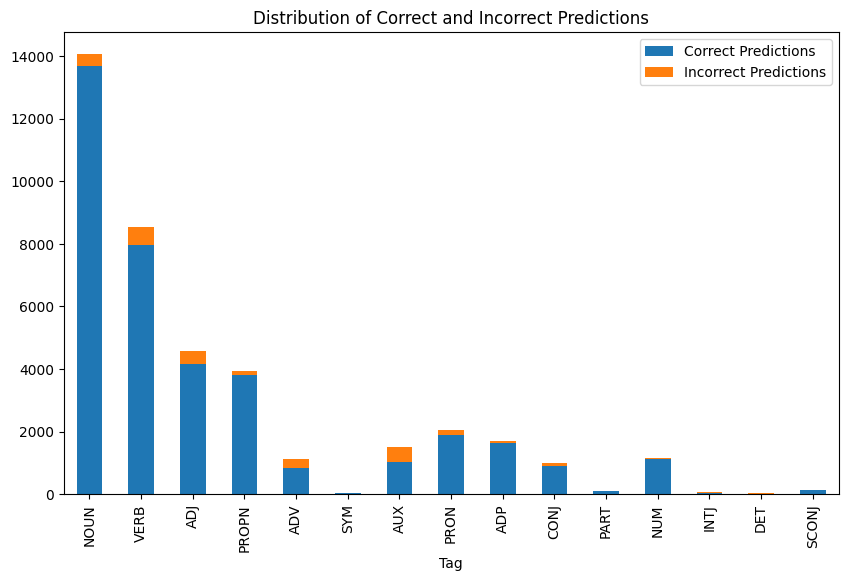

In [41]:
df_tag_dist.plot(kind='bar', # plot distribution of correct and incorrect predictions
                 x='Tag', 
                 stacked=True, 
                 figsize=(10,6), 
                 title="Distribution of Correct and Incorrect Predictions"
                 )

In [53]:
def mistake_frequency_by_word_type(y_true, y_pred, list_tags, encoder):
    
    y_true_decoded = encoder.inverse_transform(y_true)
    y_pred_decoded = encoder.inverse_transform(y_pred)

    cm = confusion_matrix(y_true_decoded, 
                          y_pred_decoded, 
                          labels=list_tags
                          )

    cm_df = pd.DataFrame(cm, 
                         index=list_tags, 
                         columns=list_tags
                         )

    mistake_freq_records = []

    for true_tag in list_tags:
        for pred_tag in list_tags:
            if true_tag != pred_tag:
                frequency = cm_df.loc[true_tag, pred_tag]
                if frequency > 0:
                    mistake_freq_records.append({'From Tag': true_tag, 
                                                 'To Tag': pred_tag, 
                                                 'Frequency': frequency}
                                                 )

    mistake_freq_df = pd.DataFrame(mistake_freq_records)

    return mistake_freq_df.sort_values(by='Frequency', ascending=False)

mistake_freq_df = mistake_frequency_by_word_type(Y_test, 
                                                 predicts_test, 
                                                 list_tags, 
                                                 encoder_tag
                                                 )

mistake_freq_df.head(n=10) # Print 10 most frequent errors

,From Tag,To Tag,Frequency
46,AUX,VERB,405
14,VERB,AUX,341
17,ADJ,NOUN,200
10,VERB,NOUN,187
36,ADV,ADJ,146
1,NOUN,ADJ,132
26,PROPN,NOUN,108
0,NOUN,VERB,107
54,PRON,NUM,100
20,ADJ,ADV,76
